In [1]:
import coldatoms
import numpy as np
%matplotlib notebook
import matplotlib.pyplot as plt

The input configuration for the ions is given by the following data set:

In [2]:
input_configuration = np.loadtxt('inputIonConfiguration.dat')

This is a matrix the rows corresponding to x, y, z, vx, vy, vz, charge, and mass. For example, the first particle has the following state:

In [3]:
input_configuration[:,0]

array([  1.00799552e-05,  -9.47328408e-06,  -9.52882956e-44,
         2.61945844e+00,   2.78756571e+00,   2.38067112e-37,
         1.60217660e-19,   1.49674940e-26])

Now we need to convert this input a coldatoms ensemble:

In [4]:
def create_ensemble(configuration):
    ensemble = coldatoms.Ensemble(configuration.shape[1])
    ensemble.x = np.ascontiguousarray(np.transpose(configuration[0:3, :]))
    ensemble.v = np.ascontiguousarray(np.transpose(configuration[3:6, :]))
    ensemble.ensemble_properties['charge'] = configuration[6, 0]
    ensemble.ensemble_properties['mass'] = configuration[7, 0]
    return ensemble

In [5]:
ensemble = create_ensemble(input_configuration)

In [6]:
print(ensemble.num_ptcls)
print(ensemble.x.shape)

127
(127, 3)


Here is a top view of the ion crystal:

<IPython.core.display.Javascript object>


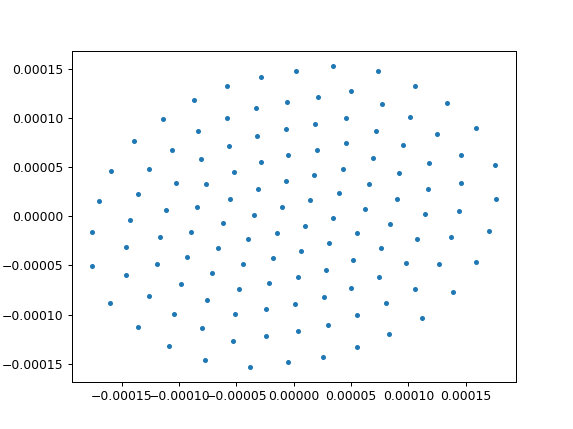

In [7]:
plt.plot(ensemble.x[:, 0], ensemble.x[:, 1], 'o', ms=3);

The strongest forces in our system are the Coulomb force and the Lorentz force due to the axial magnetic fields in the Penning trap:

In [8]:
coulomb_force = coldatoms.CoulombForce()

In [9]:
class AxialLorentzForce(object):
    """Lorentz force due to axial magnetic field in Penning trap."""
    
    def __init__(self, b_field):
        self.b_field = b_field
        
    def force(self, dt, ensemble, f):
        q = ensemble.ensemble_properties['charge']
        if q is None:
            q = ensemble.particle_properties['charge']
            if q is None:
                raise RuntimeError('Must provide ensemble or per particle charge')
            
        f += dt * self.b_field * np.column_stack(
            (q * ensemble.v[:, 1], -q * ensemble.v[:, 0], np.zeros_like(ensemble.x[:, 0])))

In [10]:
lorentz_force = AxialLorentzForce(4.458)

In [11]:
f = np.zeros_like(ensemble.v)
lorentz_force.force(1.0e-9, ensemble, f)
print(ensemble.x[0])
print(ensemble.v[0])
print(f[0])

[  1.00799552e-05  -9.47328408e-06  -9.52882956e-44]
[  2.61945844e+00   2.78756571e+00   2.38067112e-37]
[  1.99101972e-27  -1.87094905e-27   0.00000000e+00]


In [24]:
1.0e-9 * 8.85e-12 * 100.0 * 1.6e-19**2/ (1.0e-5**2)

2.2656e-46

In [22]:
1.0e-9 * 1.6e-19 * 4 * 4.5

2.88e-27

In [12]:
ensemble.ensemble_properties['charge']

1.6021765974585869e-19

The cyclotron frequency is

In [13]:
omega_cyclotron = ensemble.ensemble_properties['charge'] * 4.458 / ensemble.ensemble_properties['mass']

With a period of 

In [14]:
2.0 * np.pi / omega_cyclotron

1.316674766805686e-07

# Convergence

First we convince we investigate the error as a function of the time step size to figure out how small of a time step size we need to choose to reasonable accuracy.

In [31]:
def evolve_ensemble(dt, t_max, ensemble, forces):
    t = 0
    while t < t_max:
        coldatoms.drift_kick(dt, ensemble, forces)
        t += dt

<IPython.core.display.Javascript object>


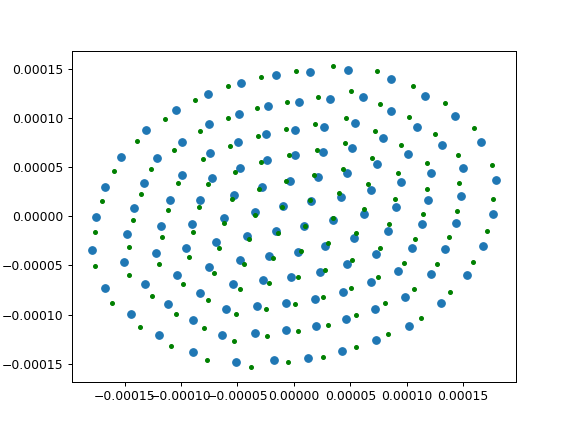

In [34]:
my_ensemble = create_ensemble(input_configuration)
evolve_ensemble(8.0e-10, 3.0e-6, my_ensemble, [coulomb_force, lorentz_force])

plt.figure()
plt.plot(my_ensemble.x[:,0], my_ensemble.x[:,1], 'o')
plt.plot(ensemble.x[:,0], ensemble.x[:,1], 'go', ms=3)